Топ 10 числовых переменных по коэффициенту взаимной информации:
['npl_days', 'target', 'id', 'avg_check_reviews_lt', 'total_replenishment_lt', 'total_replenishment_pd', 'cash_expenditure_pd', 'daily_amount_reviews_pd', 'avg_check_reviews_pd', 'calls_per_day_pd']
Распределение и описательная статистика для топ 10 числовых переменных:


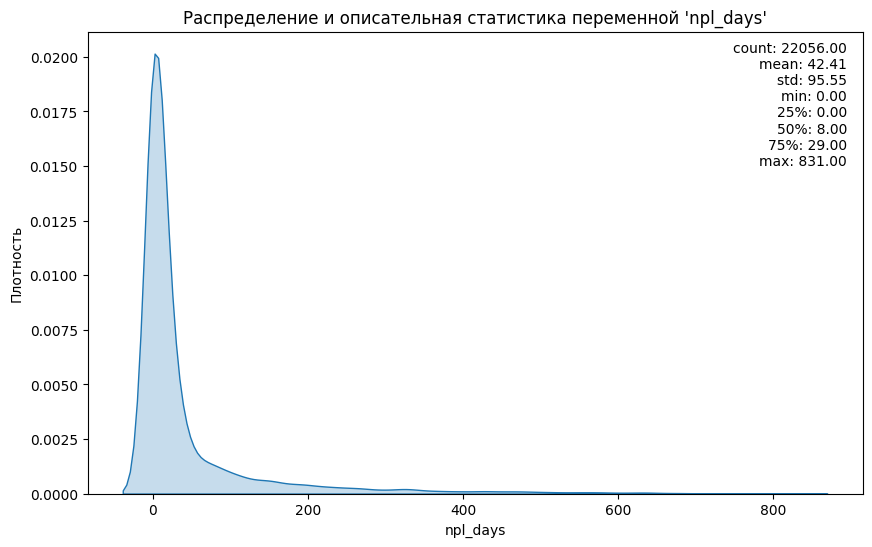

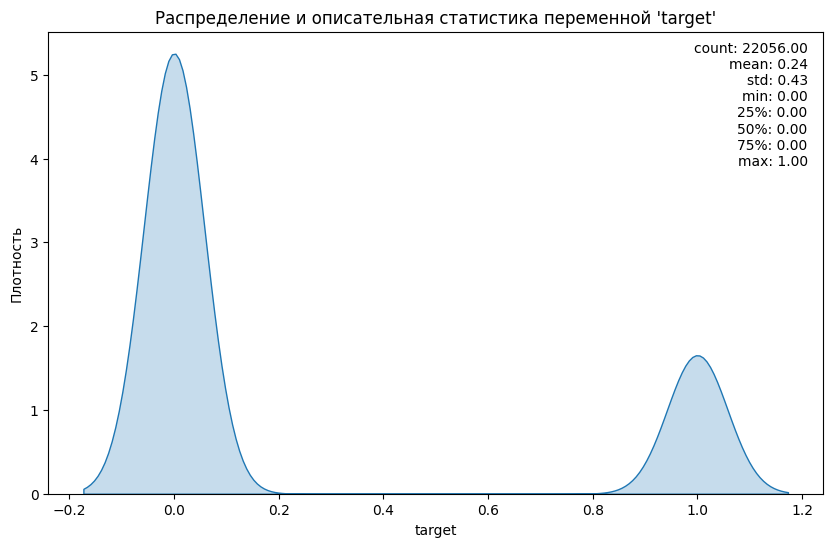

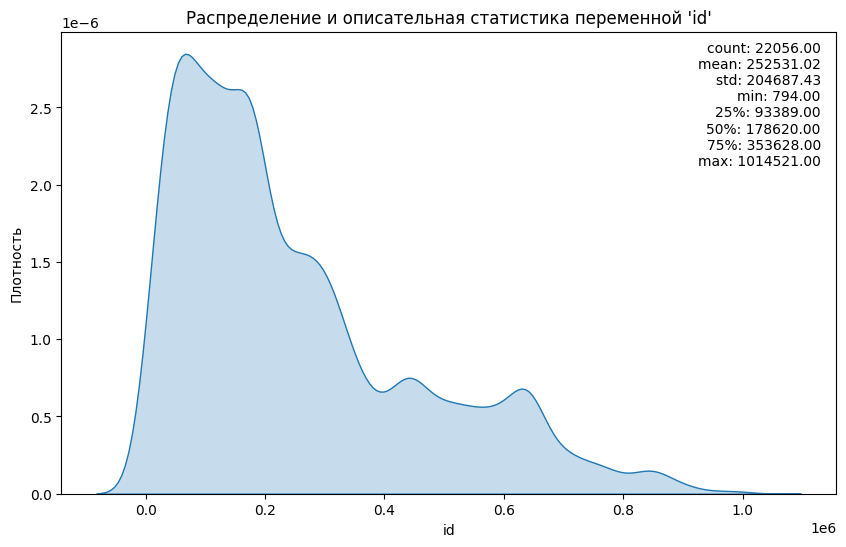

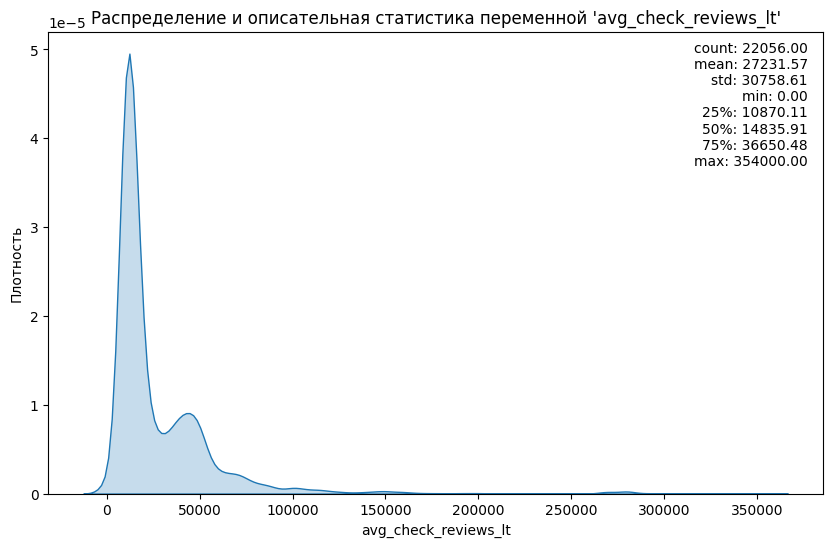

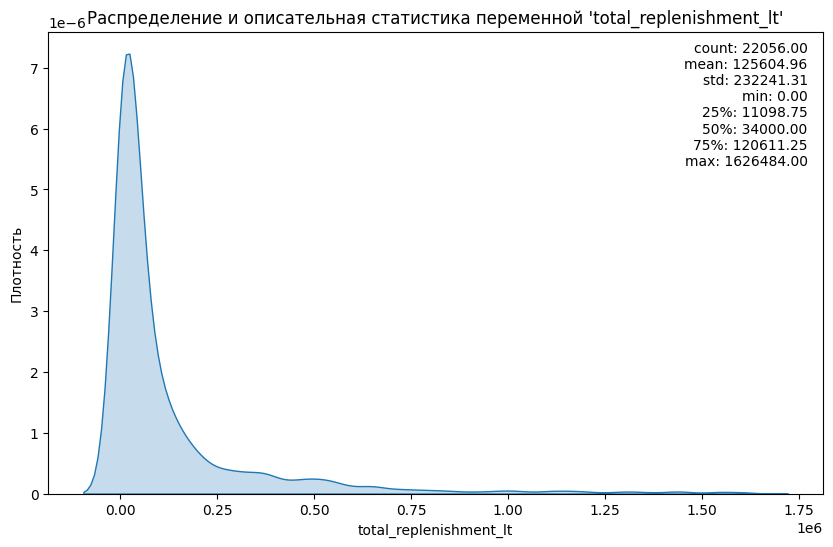

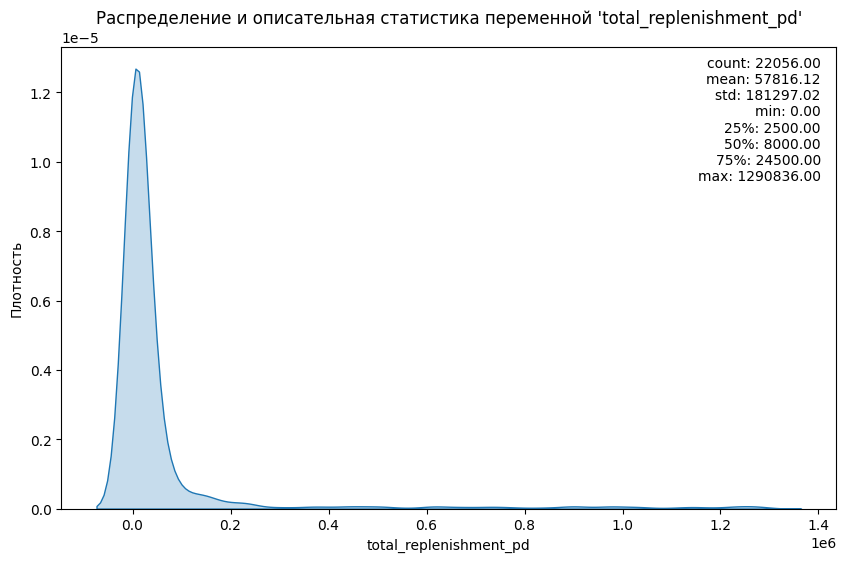

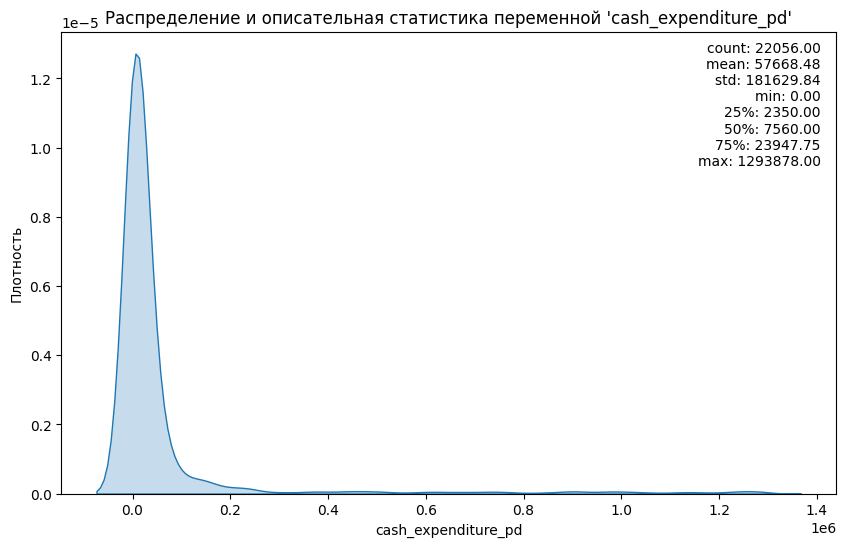

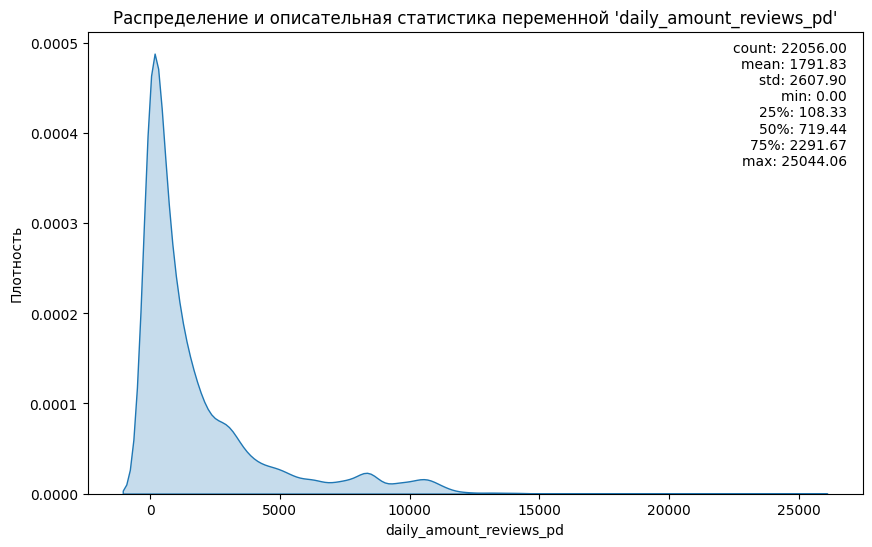

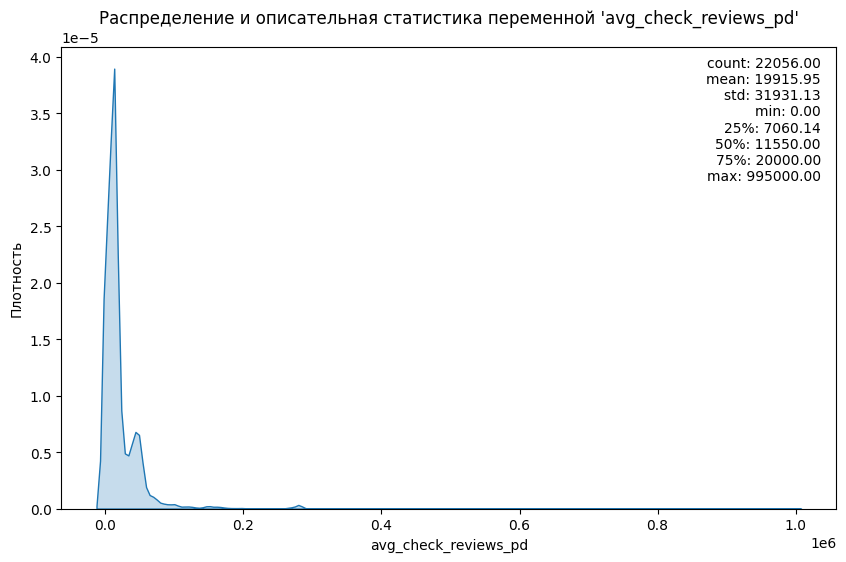

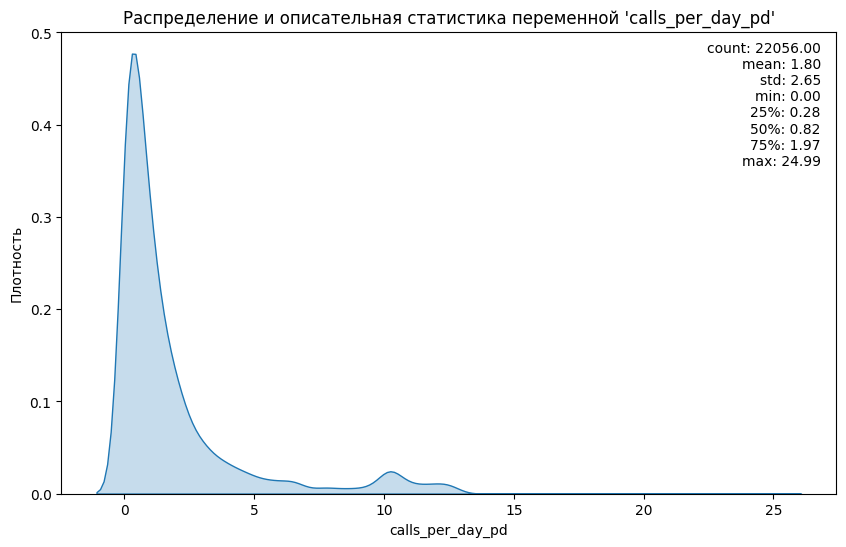

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

df = pd.read_csv(r'D:\python\1_Internship\naimi_new4_preprocessed.csv')

num_cols = df.select_dtypes(include=np.number).columns

mi_scores = mutual_info_regression(df[num_cols], df['target'])
mi_df = pd.DataFrame({'feature': num_cols, 'mi_score': mi_scores})
top_10 = mi_df.sort_values('mi_score', ascending=False).head(10)['feature'].tolist()

print("Топ 10 числовых переменных по коэффициенту взаимной информации:")
print(top_10)

print("Распределение и описательная статистика для топ 10 числовых переменных:")
for col in top_10:
    plt.figure(figsize=(10, 6))
    
    # Распределение плотности
    sns.kdeplot(data=df, x=col, shade=True)
    plt.xlabel(col)
    plt.ylabel("Плотность")
    
    # Описательная статистика
    stats = df[col].describe()
    
    # Добавление описательной статистики на график
    plt.title(f"Распределение и описательная статистика переменной '{col}'")
    plt.text(0.98, 0.98, 
             f"count: {stats['count']:.2f}\n"
             f"mean: {stats['mean']:.2f}\n"
             f"std: {stats['std']:.2f}\n"
             f"min: {stats['min']:.2f}\n"
             f"25%: {stats['25%']:.2f}\n"
             f"50%: {stats['50%']:.2f}\n" 
             f"75%: {stats['75%']:.2f}\n"
             f"max: {stats['max']:.2f}",
             va='top', ha='right', transform=plt.gca().transAxes)
    
    plt.show()


Топ 10 категориальных переменных по коэффициенту взаимной информации:
['work_start_date', 'phone_number', 'selected_service_categories_lt', 'data_collection_date', 'installment_status', 'season', 'base_city_pd', 'season_opened', 'gender_lt', 'os_lt']

Распределение категориальных переменных:


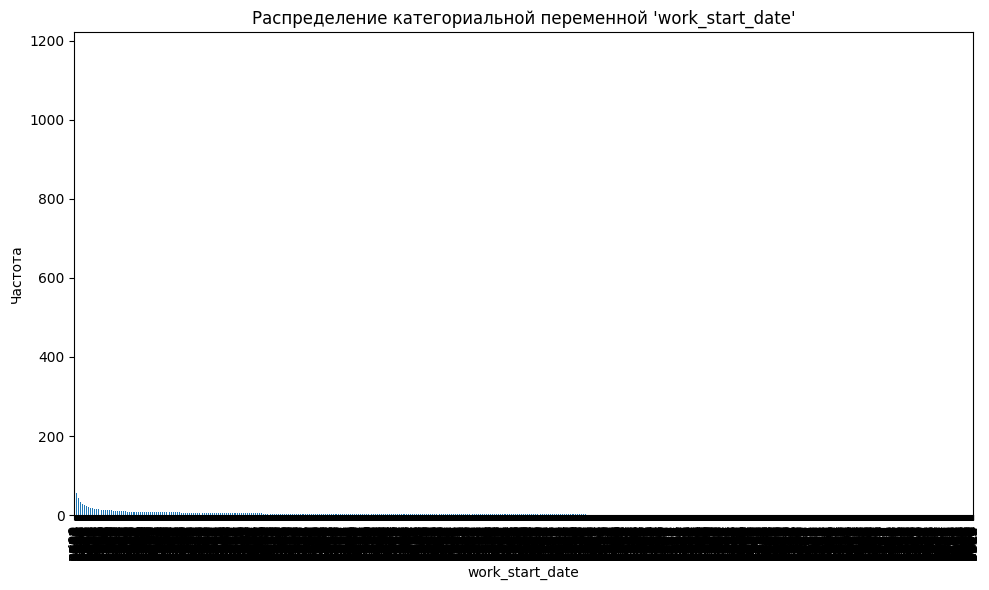

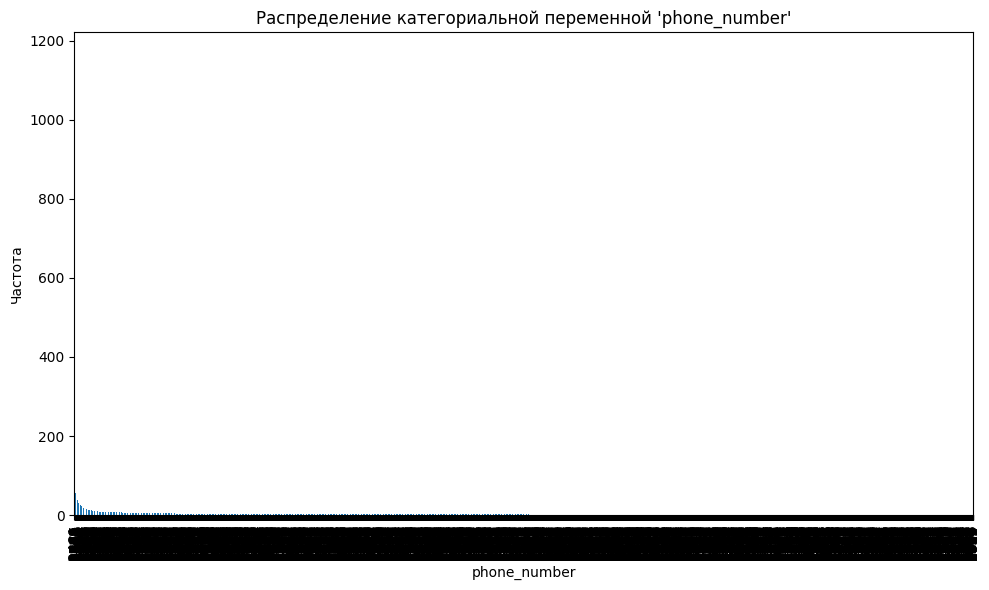

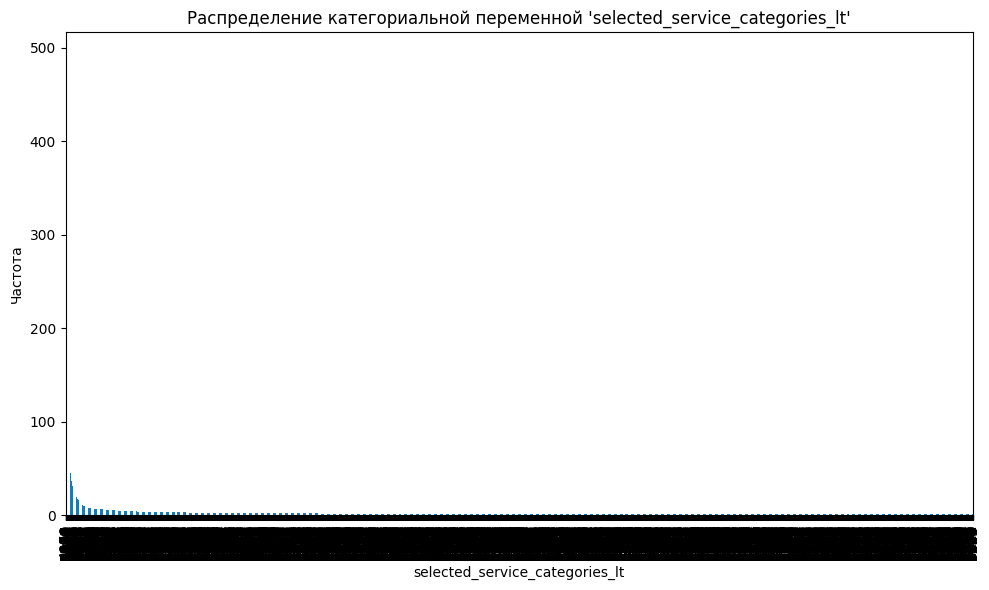

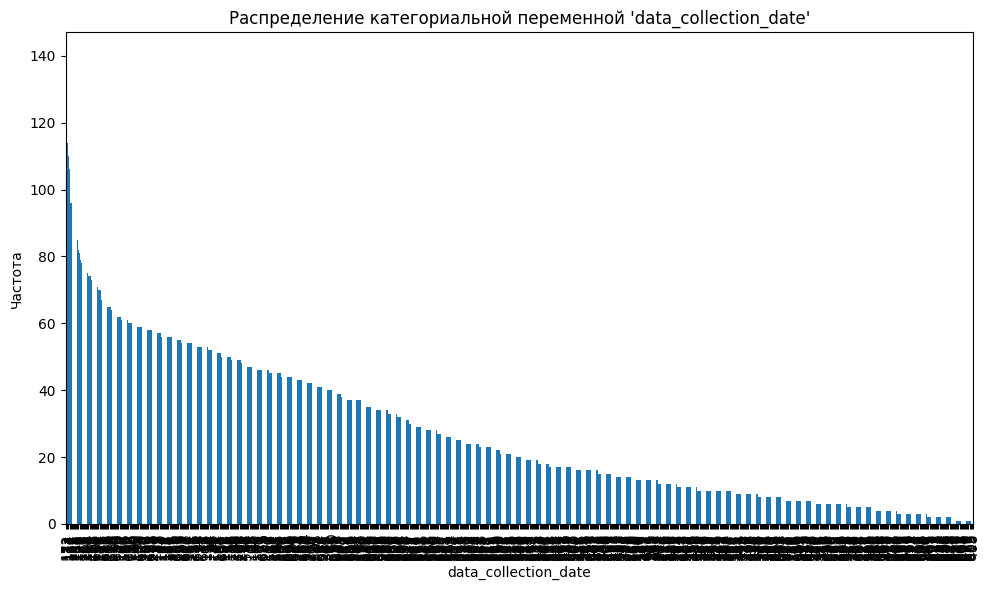

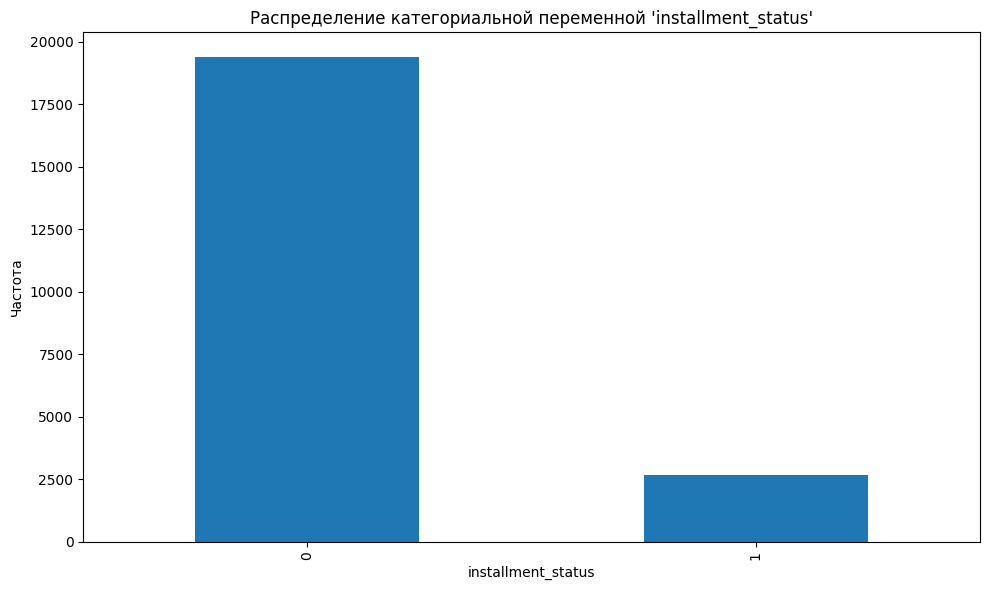

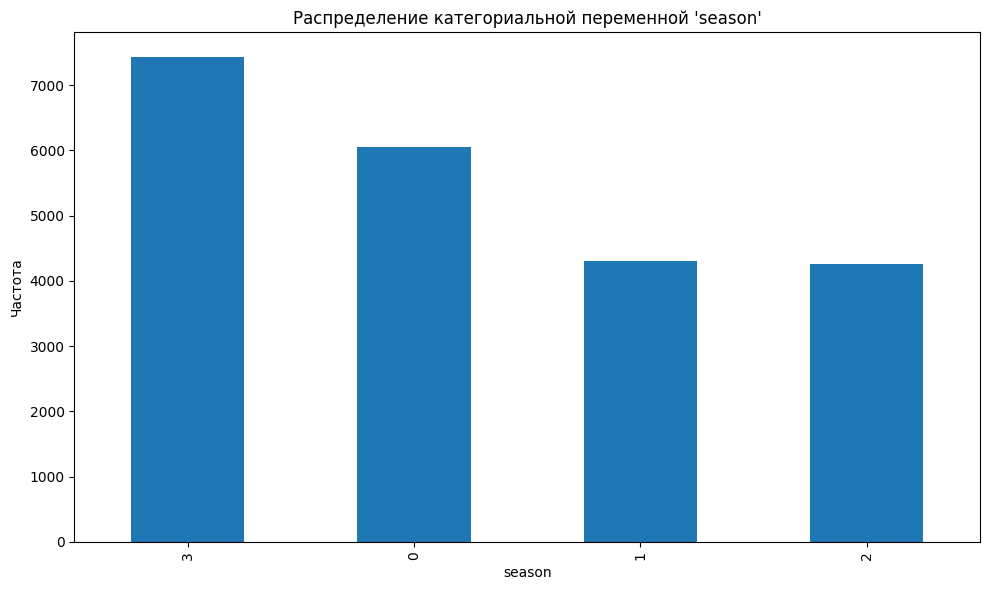

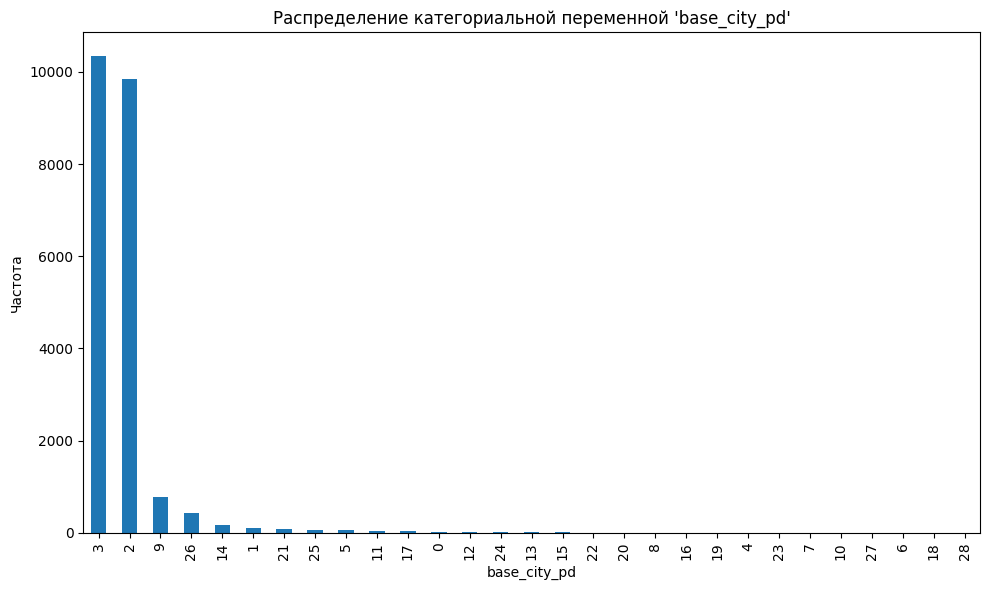

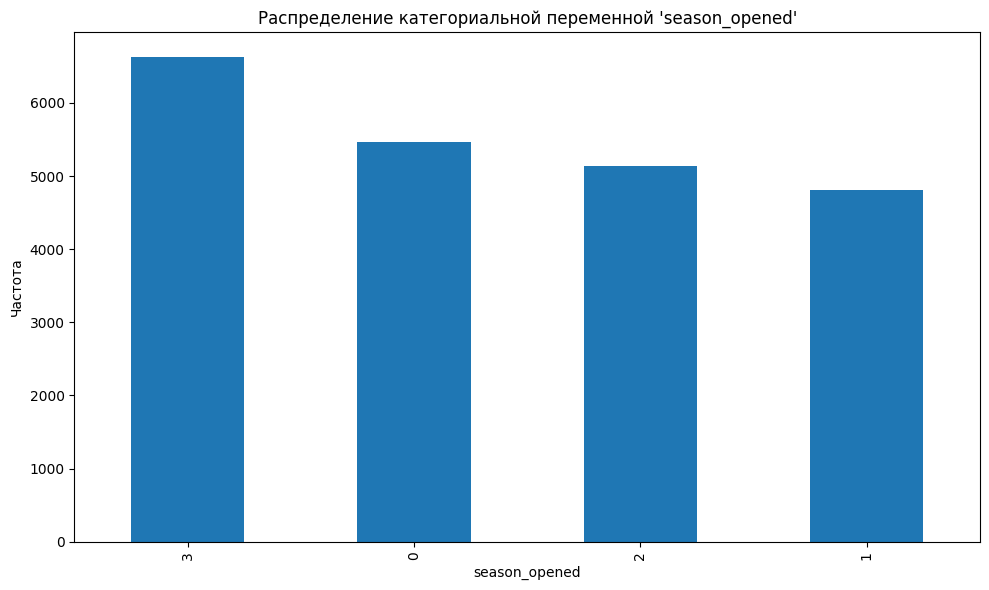

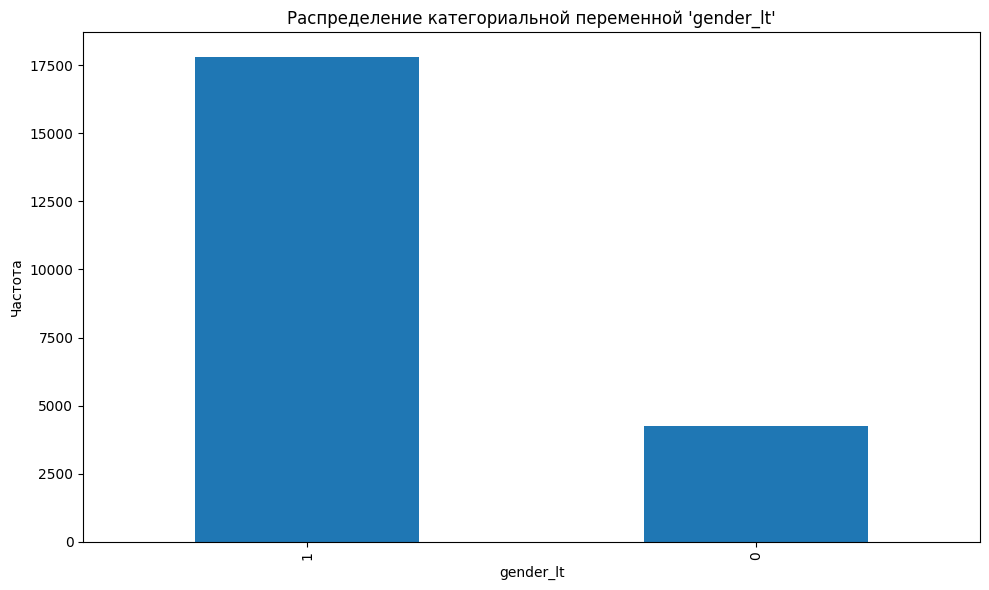

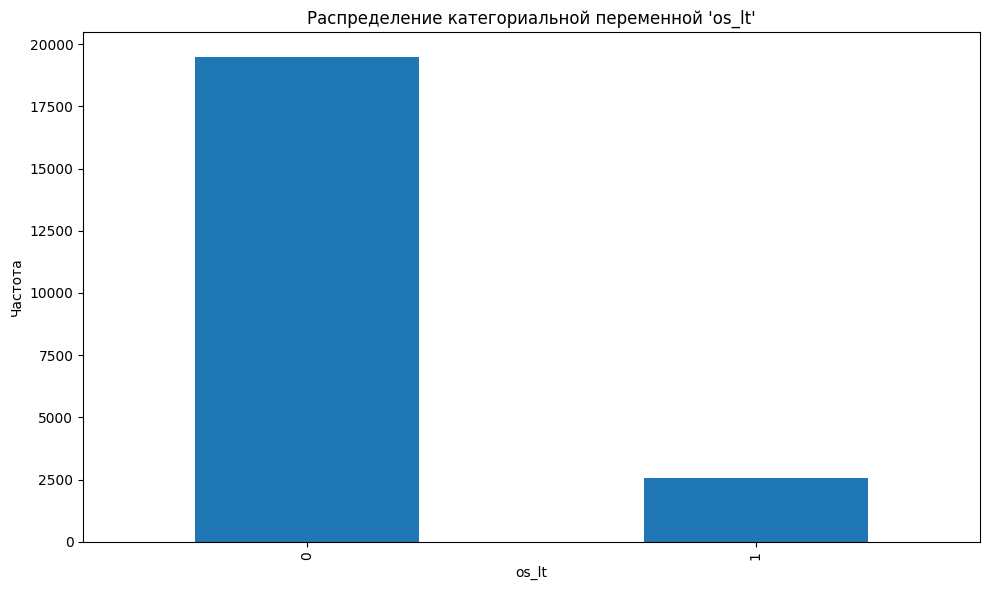

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv(r'D:\python\1_Internship\naimi_new4_preprocessed.csv', low_memory=False)

cat_cols = df.select_dtypes(exclude=np.number).columns

for col in cat_cols:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

cat_mi_scores = []
for col in cat_cols:
    mi_score = mutual_info_classif(df[[col]], df['target'])[0]
    cat_mi_scores.append(mi_score)

cat_mi_df = pd.DataFrame({'feature': cat_cols, 'mi_score': cat_mi_scores})

top_10_cat = cat_mi_df.sort_values('mi_score', ascending=False).head(10)['feature'].tolist()

print("Топ 10 категориальных переменных по коэффициенту взаимной информации:")
print(top_10_cat)

print("\nРаспределение категориальных переменных:")

for col in top_10_cat:
    plt.figure(figsize=(10, 6))
    df[col].value_counts().plot(kind='bar')
    plt.title(f"Распределение категориальной переменной '{col}'")
    plt.xlabel(col)
    plt.ylabel("Частота")
    plt.tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
import pickle

with open(r'D:\python\1_Internship\cbc_final_model.pkl', 'rb') as f:
    model = pickle.load(f)

data = pd.read_csv(r'D:\python\1_Internship\naimi_new4_preprocessed.csv', low_memory=False)

label_encoder = LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:
    data[col] = label_encoder.fit_transform(data[col])

X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

def threshold_breakdown(train_set, test_set, target='target', prediction='model1_prediction'):
    model_threshold_list = []

    for thres in [x / 100 for x in range(30, 70, 5)]:
        thres_metrics = dict()

        train_set['prediction_label'] = (train_set[prediction] > thres).astype(int)
        test_set['prediction_label'] = (test_set[prediction] > thres).astype(int)

        tn_train, fp_train, fn_train, tp_train = confusion_matrix(train_set[target], train_set['prediction_label']).ravel()
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(test_set[target], test_set['prediction_label']).ravel()
        thres_metrics['Threshold'] = int(thres * 100)
        thres_metrics['AUC Train'] = round(roc_auc_score(train_set[target], train_set[prediction]), 2)
        thres_metrics['AUC Blind'] = round(roc_auc_score(test_set[target], test_set[prediction]), 2)
        thres_metrics['Accuracy Train'] = accuracy_score(train_set[target], train_set['prediction_label'])
        thres_metrics['Accuracy Blind'] = accuracy_score(test_set[target], test_set['prediction_label']) 
        thres_metrics['Approval Train rate'] = round((fn_train + tn_train) / (tn_train + fp_train + fn_train + tp_train), 4)
        thres_metrics['Approval Blind rate'] = round((fn_test + tn_test) / (tn_test + fp_test + fn_test + tp_test), 4) 
        thres_metrics['Good found Train'] = round(tn_train / (fp_train + tn_train), 4)
        thres_metrics['Good found Blind'] = round(tn_test / (fp_test + tn_test), 4)  
        thres_metrics['Bad found Train'] = round(tp_train / (fn_train + tp_train), 4)
        thres_metrics['Bad found Blind'] = round(tp_test / (fn_test + tp_test), 4) 

        model_threshold_list.append(thres_metrics)
    
    return pd.DataFrame(model_threshold_list)

pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

threshold_df = threshold_breakdown(
    train_set=pd.DataFrame({'target': y_train, 'model1_prediction': model.predict_proba(X_train)[:,1]}),
    test_set=pd.DataFrame({'target': y_test, 'model1_prediction': y_pred_proba[:,1]})
)

print(threshold_df)

   Threshold  AUC Train  AUC Blind  Accuracy Train  Accuracy Blind  \
0         30       0.81        0.8        0.736114        0.730734   
1         35       0.81        0.8        0.769270        0.759973   
2         40       0.81        0.8        0.788257        0.778332   
3         45       0.81        0.8        0.793754        0.787851   
4         50       0.81        0.8        0.788370        0.783998   
5         55       0.81        0.8        0.777828        0.777199   
6         60       0.81        0.8        0.769893        0.768359   
7         65       0.81        0.8        0.767003        0.764053   

   Approval Train rate  Approval Blind rate  Good found Train  \
0               0.6340               0.6401            0.7432   
1               0.7360               0.7405            0.8320   
2               0.8242               0.8286            0.9025   
3               0.8920               0.8985            0.9506   
4               0.9433               0.9449 